In [1]:
import sf_quant as sf
import polars as pl
import datetime as dt

import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv

/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-26 17:25:18,388	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
load_dotenv()
factor_path = os.getenv("FACTOR_TABLE")
factor_returns = pl.read_parquet(factor_path).melt(id_vars='date', variable_name='factor', value_name='ret')
factor_returns

/tmp/ipykernel_1792470/3412504384.py:3: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  factor_returns = pl.read_parquet(factor_path).melt(id_vars='date', variable_name='factor', value_name='ret')


date,factor,ret
date,str,f64
1995-06-30,"""USSLOWL_AERODEF""",0.014816
1995-07-03,"""USSLOWL_AERODEF""",-0.534163
1995-07-05,"""USSLOWL_AERODEF""",-0.035338
1995-07-06,"""USSLOWL_AERODEF""",-0.134558
1995-07-07,"""USSLOWL_AERODEF""",0.2649769
…,…,…
2025-09-09,"""USSLOWL_WIRELESS""",-0.158258
2025-09-10,"""USSLOWL_WIRELESS""",-1.219652
2025-09-11,"""USSLOWL_WIRELESS""",-0.285465


In [3]:
factor_returns = factor_returns.sort(['factor', 'date']).with_columns(
    pl.col('ret').shift(1).over('factor').alias('lag_ret')
)
factor_returns

date,factor,ret,lag_ret
date,str,f64,f64
1995-06-30,"""USSLOWL_AERODEF""",0.014816,null
1995-07-03,"""USSLOWL_AERODEF""",-0.534163,0.014816
1995-07-05,"""USSLOWL_AERODEF""",-0.035338,-0.534163
1995-07-06,"""USSLOWL_AERODEF""",-0.134558,-0.035338
1995-07-07,"""USSLOWL_AERODEF""",0.2649769,-0.134558
…,…,…,…
2025-09-09,"""USSLOWL_WIRELESS""",-0.158258,-1.537404
2025-09-10,"""USSLOWL_WIRELESS""",-1.219652,-0.158258
2025-09-11,"""USSLOWL_WIRELESS""",-0.285465,-1.219652


In [ ]:
factor_returns = (factor_returns.with_columns(
    pl.col("lag_ret").rank('dense').over('date').alias('rank'),
    pl.col('lag_ret').count().over('date').alias('count')
))
factor_returns

date,factor,ret,lag_ret,rank,count
date,str,f64,f64,u32,u32
1995-06-30,"""USSLOWL_AERODEF""",0.014816,null,null,0
1995-07-03,"""USSLOWL_AERODEF""",-0.534163,0.014816,35,77
1995-07-05,"""USSLOWL_AERODEF""",-0.035338,-0.534163,5,77
1995-07-06,"""USSLOWL_AERODEF""",-0.134558,-0.035338,32,77
1995-07-07,"""USSLOWL_AERODEF""",0.2649769,-0.134558,26,77
…,…,…,…,…,…
2025-09-09,"""USSLOWL_WIRELESS""",-0.158258,-1.537404,1,76
2025-09-10,"""USSLOWL_WIRELESS""",-1.219652,-0.158258,33,76
2025-09-11,"""USSLOWL_WIRELESS""",-0.285465,-1.219652,4,76


In [5]:
factor_returns = (factor_returns.with_columns(
    pl.when(pl.col('rank') >= pl.col('count')/2)
    .then(1)
    .otherwise(-1)
    .alias('signal')
))
factor_returns

date,factor,ret,lag_ret,rank,count,signal
date,str,f64,f64,u32,u32,i32
1995-06-30,"""USSLOWL_AERODEF""",0.014816,null,null,0,-1
1995-07-03,"""USSLOWL_AERODEF""",-0.534163,0.014816,35,77,-1
1995-07-05,"""USSLOWL_AERODEF""",-0.035338,-0.534163,5,77,-1
1995-07-06,"""USSLOWL_AERODEF""",-0.134558,-0.035338,32,77,-1
1995-07-07,"""USSLOWL_AERODEF""",0.2649769,-0.134558,26,77,-1
…,…,…,…,…,…,…
2025-09-09,"""USSLOWL_WIRELESS""",-0.158258,-1.537404,1,76,-1
2025-09-10,"""USSLOWL_WIRELESS""",-1.219652,-0.158258,33,76,-1
2025-09-11,"""USSLOWL_WIRELESS""",-0.285465,-1.219652,4,76,-1


In [10]:
port = (factor_returns.group_by(['date', 'signal'])
        .agg(pl.col('ret').mean().alias('mean_ret'))
        .sort(['signal', 'date'])
        .pivot(on='signal', index='date', values='mean_ret')
        .drop_nulls()
        )
port

date,-1,1
date,f64,f64
1995-07-03,-0.051201,0.038668
1995-07-05,0.047922,0.300512
1995-07-06,0.063506,0.153767
1995-07-07,-0.092409,0.420489
1995-07-10,-0.26641,0.283483
…,…,…
2025-09-09,-0.407913,-0.275236
2025-09-10,0.364306,0.060137
2025-09-11,0.188257,0.129127


[]

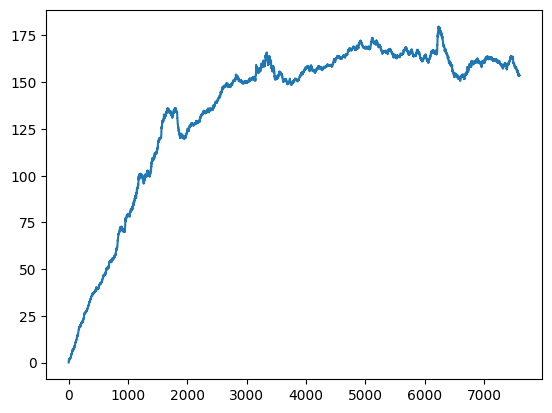

In [14]:
plt.plot((port['1']-port['-1']).cum_sum())
plt.plot()